# Agent-baseret simulation af et simpelt marked

Først importeres de nødvendige biblioteker:

In [177]:
import matplotlib 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 5)
import pandas as pd
import numpy as np
import math
import importlib
import marketlib
importlib.reload(marketlib);

## Markedsparametre

In [178]:
# Skalering af efterspørgselskurven - svarer til markedets størrelse. Delta kan være hvilket som helst positivt tal 
Δ = 10

# Alpha: hvor meget forbrugere vil efterspørge, hvis prisen er nul
alpha = 10.5*Δ

# Beta: hældning på demand-kurve, hvor stor effekt prisen på varen har på efterspørgslen
beta = 1.75*Δ

# Theta: afgører hvilken indflydelse det har at prisen afviger fra markedsgennemsnittet
theta = 1.45833*Δ

# Marginal produktionsomkostninger
c = 8

# Saml model parametre 
mp = {'alpha': alpha, 'beta': beta, 'theta': theta, 'c': c}

# Hvor mange tids-skridt skal simuleringen køre?
time_steps = 200

# Antal agenter (bliver overskrevet hvis man anvender de empiriske agenter alene)
num_agents = 200

## Agent parametre

In [179]:
# Hvor mange penge har hver agent når simulationen går i gang?
initial_endowment = 500*Δ

# Hvilket produktionsniveau starter agenterne på?
initial_production = 7.5*Δ

# Hvilken pris sætter agenterne i starten?
initial_price = 14

# Angiv andel af agenterne, der følger flokken i prissætning
share_herding = 0.3
num_agents_herding = int(share_herding * num_agents)
num_agents_best_response = int((1 - share_herding)*num_agents)

# Standardafvigelser på fejlled/chok i hhv. forventninger (epsilon), prissætning (u), mængder (eta)
# Anvendes i create_agents()
std_epsilon = 0.1
std_u = 0
std_eta = 0


# Hent parametre til agenters adfærd - best response
pe_params_br, p_params_br, q_params_br, num_agents_best_response = marketlib.get_parameters(mp,
                                                                            agent_type = "best_response",
                                                                            num_agents = num_agents_best_response)

# Modificer selv parametre i fx. forventinger til priser blandt herding agenter
# Alle 3 sæt parametre kan ændres
pe_means_herding = {"c": 0.0,
                    "alpha_1": 0.5,
                    "alpha_2": 0.5,
                    "alpha_3": 0.0}

# std_scale standardafvigelsen på agentparametrene som ratio ift parametrenes værdi. Dvs std = std_scale * parameter, mean = parameter
std_scale_herding = 0.1

# Parametre til agenters adfærd - herding
pe_params_h, p_params_h, q_params_h, num_agents_herding = marketlib.get_parameters(mp,
                                                                            agent_type = "herding",
                                                                            num_agents = num_agents_herding,
                                                                            std_scale = std_scale_herding,
                                                                            pe_means = pe_means_herding)

# Saml best response parametre og herding parametre i 1 data frame for hver parameter klasse
pe_params = pd.concat([pe_params_br, pe_params_h], ignore_index=True)
p_params = pd.concat([p_params_br, p_params_h], ignore_index=True)
q_params = pd.concat([q_params_br, q_params_h], ignore_index=True)

#pe_params.reset_index(drop = True);
#p_params.reset_index(drop = True);
#q_params.reset_index(drop = True);

## Beregning af efterspørgsel

Efterspørgsels-funktionen for markedet

In [180]:
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

## Opret agenterne

In [181]:
def create_agents(n):
    # Tom liste af agenter
    agents = []

    # Opret så mange agenter vi har brug for
    # og gem dem i listen
    for i in range(n):
        agent = marketlib.Producer(initial_price,
                                   initial_production,
                                   initial_endowment,
                                   c = c,
                                   pe = pe_params.iloc[i],
                                   p = p_params.iloc[i],
                                   q = q_params.iloc[i],
                                   epsilon = std_epsilon,
                                   u = std_u,
                                   eta = std_eta)
        agents.append(agent)
    return agents

## Beskriv ét trin af simuleringen

In [182]:
def simulation_step(agents, t, mean_prices):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_prices[t-1], mean_prices[t-2])
        agent.set_production_level()

    # Aflæs priser og beregn markedspris
    prices_t = [a.price for a in agents]
    mean_price_t = np.nanmean(prices_t)

    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.calculate_profit(d)
        agent.update_price_adjustment()

    return prices_t, mean_price_t

## Kør simuleringen
Simpleste måde at køre simuleringen, hvor vi kun gemmer gennemsnitspriserne, og plotter dem.

In [183]:
# Da agenterne er bagudskuende mht observerede priser er det nødvendigt at definere en kunstig 
# 'forhistorie' til simulationen bestående af brugerdefinerede priser i en antal perioder
t_prehist = 3

# Initier data frame til gennemsnitlige priser
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices[0:t_prehist] = initial_price

# Skab agenter
agents = create_agents(num_agents)

# Kør simulering
for t in range(t_prehist, time_steps):
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])
    
    # Gem gennemsnitsprisen
    mean_prices.iloc[t] = mean_price_t

# Vis gennemsnitlig pris over tid

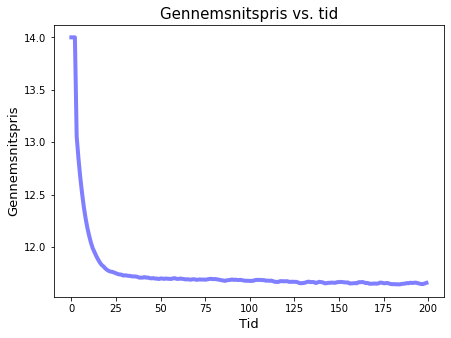

In [184]:
mean_prices.plot(legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
plt.title("Gennemsnitspris vs. tid", weight = 'roman', size = 15)
plt.xlabel('Tid', weight = 'roman', size = 13)
plt.ylabel('Gennemsnitspris', weight = 'roman', size = 13);

## Kør simuleringen - og gem flere informationer

Kør simuleringen igen, denne gang gemmer vi meget mere information, for at kunne plotte de enkelte agenters opførsel, samt opførslen 

In [185]:
# Opret tabeller til at gemme hver agents pris/produktion/profit, som
# vi kan bruge når vi skal lave grafer
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = ["1"])

mean_productions[0:t_prehist] = initial_production
mean_prices[0:t_prehist] = initial_price
mean_profits[0:t_prehist] = 0

agents = create_agents(num_agents)
    
for t in range(3, time_steps):
    # Kør simulering
    prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,0])

    # Aflæs produktion og profit fra agenter
    quantities_t = [a.quantity for a in agents]
    profits_t = [a.profit for a in agents]

    # Beregn gennemsnitlig produktion og profit
    mean_production_t = np.nanmean(quantities_t)
    mean_profit_t = np.nanmean(profits_t)
    
    # Gem agenters profit, priser og produktionsmængder til plots
    profit_df.loc[t] = profits_t
    price_df.loc[t] = prices_t
    quantity_df.loc[t] = quantities_t

    mean_productions.iloc[t] = mean_production_t
    mean_prices.iloc[t] = mean_price_t
    mean_profits.iloc[t] = mean_profit_t
        
    #print(f"{t}: Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

### Plot resultater

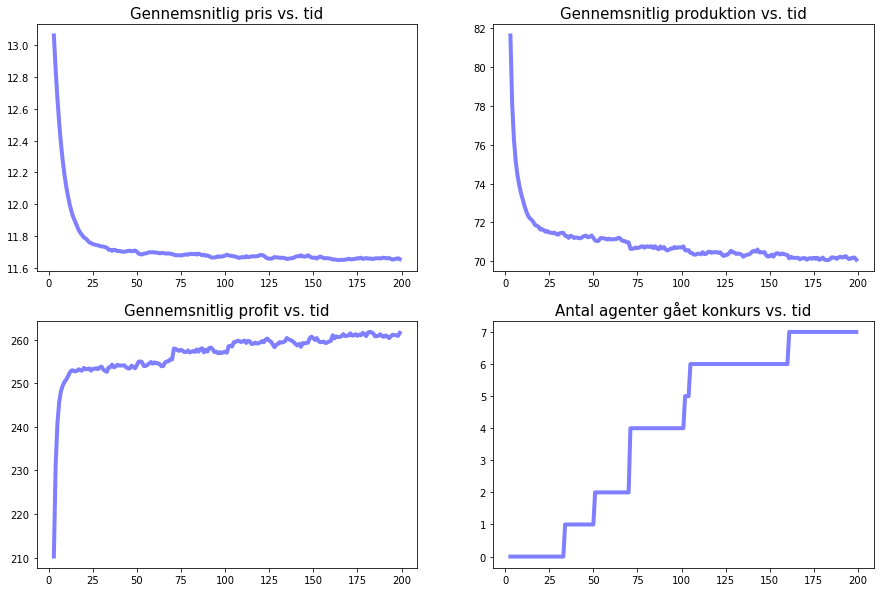

In [186]:
# Initier subplots og sæt figurstørrelse
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_size_inches(15, 10)

# Begynd plots fra periode t_0. Kan sættes til 0 og op. 
# Anvendelig da simulationen er mere volatil i begyndelsen pga start betingelserne.
t_0 = 0

# Indsæt plot for alle agenternes individuelle historik
mean_prices[t_prehist:].plot(ax = axes[0,0], legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
axes[0, 0].set_title('Gennemsnitlig pris vs. tid', weight = 'roman', size = 15)
#axes[0, 0].set_ylim(9,15)

mean_productions[t_prehist:].plot(ax = axes[0,1], legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
axes[0, 1].set_title('Gennemsnitlig produktion vs. tid', weight = 'roman', size = 15)
#axes[0, 1].set_ylim(0,20)

mean_profits[t_prehist:].plot(ax = axes[1,0], legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
axes[1, 0].set_title('Gennemsnitlig profit vs. tid', weight = 'roman', size = 15)
#axes[1, 0].set_ylim(-20,100)

n_bankruptcies = price_df.isna().sum(axis=1)
n_bankruptcies[t_prehist:].plot(ax = axes[1,1], legend = None, color = 'blue', alpha = 0.5, linewidth = 4)
axes[1, 1].set_title('Antal agenter gået konkurs vs. tid', weight = 'roman', size = 15)

plt.show()


## Plot kurver for hver enkelt agent

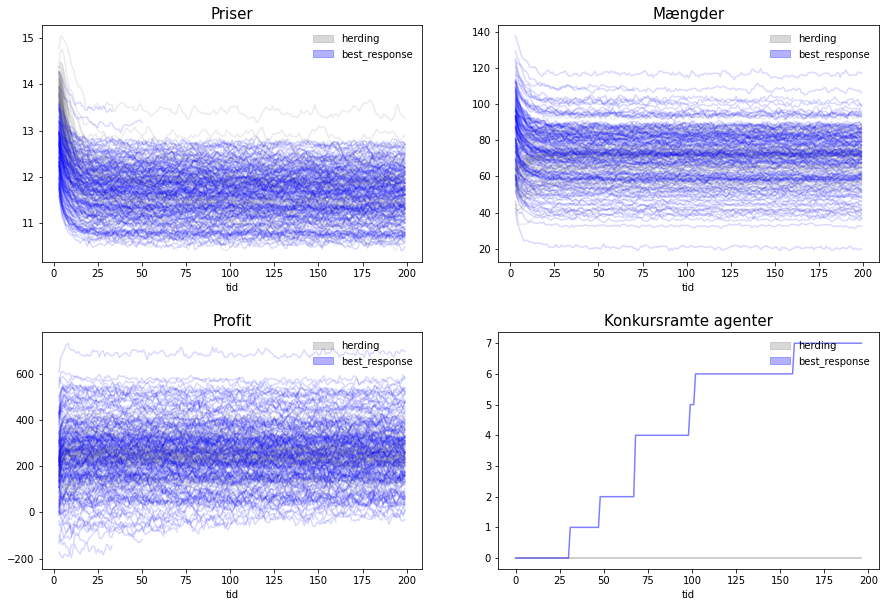

In [187]:
# Definer farver i plots
type_colors = {'herding': 'grey', 'best_response': 'blue'}
agent_types = ['herding', 'best_response']

# Kreer liste af farver i legend 
lpatch = []
for t in agent_types:
    lpatch.append(matplotlib.patches.Patch(color=type_colors[t], alpha = 0.3, label=t))

# Initier subplots og sæt figurstørrelse
fig, axes = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.3)
fig.set_size_inches(15, 10)

# Figur for individuelle priser 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    price_df.iloc[:,idx].plot(ax = axes[0,0], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[0, 0].set_title('Priser', weight = 'roman', size = 15);
# axes[0, 0].set_ylim(9,15)
axes[0, 0].set_xlabel('tid');
axes[0, 0].legend(handles = lpatch, loc = 1, frameon = False);

# Figur for individuelle produktionsmængder 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    quantity_df.iloc[:,idx].plot(ax = axes[0,1], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[0, 1].set_title('Mængder', weight = 'roman', size = 15);
# axes[0, 1].set_ylim(9,15)
axes[0, 1].set_xlabel('tid');
axes[0, 1].legend(handles = lpatch, loc = 1, frameon = False);


# Figur for individuel profit 
for t in agent_types:
    idx = p_params[p_params['agent_type'] == t].index.tolist()
    profit_df.iloc[:,idx].plot(ax = axes[1,0], legend = None, color = type_colors[t], alpha = 0.15)
    
axes[1, 0].set_title('Profit', weight = 'roman', size = 15);
# axes[1, 0].set_ylim(9,15)
axes[1, 0].set_xlabel('tid');
axes[1, 0].legend(handles = lpatch, loc = 1, frameon = False);


# Figur med andel overlevende agenter
for t in agent_types:
    df = price_df.iloc[t_prehist:,p_params[p_params['agent_type'] == t].index.tolist()]
    n_bankruptcies = df.isna().sum(axis=1)
    plt.plot(range(len(n_bankruptcies)), n_bankruptcies,  color = type_colors[t], alpha = 0.50)

axes[1, 1].set_title('Konkursramte agenter', weight = 'roman', size = 15);
# axes[1, 0].set_ylim(9,15)
axes[1, 1].set_xlabel('tid');
axes[1, 1].legend(handles = lpatch, loc = 1, frameon = False);

## Gentag simulering

In [ ]:
# Antal gentagelser
repetitions = 50

cols = ["r" + str(i) for i in range(repetitions)]
mean_productions = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_prices = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)
mean_profits = pd.DataFrame(np.nan, index = range(time_steps), columns = cols)

mean_productions[0:3] = initial_production
mean_prices[0:3] = initial_price
mean_profits[0:3] = 0

for r in range(repetitions):
    agents = create_agents(num_agents)
    
    for t in range(3, time_steps):
        prices_t, mean_price_t = simulation_step(agents, t, mean_prices.iloc[:,r])

        # Aflæs produktion og profit fra agenter
        #quantities_t = marketlib.get_attr(agents, "quantity")
        #profits_t = marketlib.get_attr(agents, "profit")
        quantities_t = [a.quantity for a in agents]
        profits_t = [a.profit for a in agents]
    
        # Beregn gennemsnitlig produktion og profit
        mean_production_t = np.nanmean(quantities_t)
        mean_profit_t = np.nanmean(profits_t)
        
        # Gem data til plots
        mean_productions.iloc[t,r] = mean_production_t
        mean_prices.iloc[t,r] = mean_price_t
        mean_profits.iloc[t,r] = mean_profit_t
        
    print(f"{r}:   Mean price: {mean_price_t:.2f}  -  Mean production: {mean_production_t:.2f}")

In [ ]:
mean_profits.mean(1).plot()

In [ ]:
mean_prices.mean(1).plot()

In [ ]:
mean_productions.mean(1).plot()

In [ ]:
statistics = mean_prices.agg(['mean', 'count', 'std'], axis=1)
print(statistics)
print('-'*30)

ci95_hi = []
ci95_lo = []

for i in statistics.index:
    m, c, s = statistics.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

statistics['ci95_hi'] = ci95_hi
statistics['ci95_lo'] = ci95_lo
statistics.loc[:,["ci95_hi", "mean", "ci95_lo"]].plot()

### Teoretiske priser fra artikel (Monopolistisk konkurrence, Nash ligevægt, Best response)

In [ ]:
α = 10.5
β = 1.75
θ = 1.45833
c = 8
θ_p = θ/(2*β)
α_p = α/(2*β)
n = 10

def p_mc(c_in): 
    return (1/(1-θ_p))*(α_p + c_in/2)

def p_ne(n):
    θ_n = (θ*(n-1))/(2*(n*β-θ))
    α_n = (α*n)/(2*(n*β-θ))
    return (1/(1-θ_n))*(α_n + c/2)

def p_br(p_bar):
    return α_p + c/2 + θ_p*p_bar

c1 = 8
c2 = 10


print("Teoretisk monopolitisk pris når c = 8 : ", p_mc(c1))
print("Teoretisk stigning i pris når c stiger fra 8 til 10: ", p_mc(c2) - p_mc(c1))
